In [1]:
%load_ext autoreload


In [2]:
import os
import numpy as np
from matplotlib import pyplot as plt
import george
from george import kernels
import emcee
import scipy.optimize as op
import cmasher as cmr
import corner    
import multiprocessing as mpr
mpr.set_start_method('fork')
import gp_init_threads as th_init
from nudot_prof_functions import (get_gp, run_each_gp, plot_eig_gp, plot_recon_profs)

%aimport -os -np -plt -george -kernels -emcee -op -cmr -mpr -corner
%autoreload 2


In [3]:
#set up some plotting stuff
plt.style.use('default')
cmap = cmr.chroma
c1 = cmap(0.0)
c2 = cmap(0.3)
c3 = cmap(0.53)
c4 = cmap(0.65)
c5 = cmap(0.78)
c6 = cmap(0.915)


In [4]:
#corner.corner?

In [5]:
# dealing with uncertainties, want a kernel or function incorporating the noise and some scaling factor
# maybe some sort of EFAC and EQUAD
# check how reasonable the errorbars are on the eigenvalues, maybe remove the EFAC term
# something like A*C(x1,x2) + EF*N + EQ*I (A is amplitude, C is regular kernel, N is noise, I is the identity matrix)
#george.GP.compute?

In [6]:
data_dir = '/home/s86932rs/research/nudot_stuff/'
plots_dir = os.path.join(data_dir, 'plots')
psr = '2043+2740'
freq = 1400
npz_file = os.path.join(data_dir, psr+'_{}_eigs.npz'.format(freq))
exist_AFB = True
exist_DFB = True
with np.load(npz_file) as d:
    if 'AFB_errs' in d.keys():
        AFB_errs = d['AFB_errs']
        AFB_mean = d['AFB_mean']
        AFB_eigval = d['AFB_values']
        AFB_eigvec = d['AFB_vectors']
        AFB_eigval_bin = d['AFB_bin_vals']
        AFB_mjds = d['AFB_mjds']
        AFB_mjds_bin = d['AFB_bin_mjds']
        AFB_rms = d['AFB_rms']
    else:
        exist_AFB = False
        
    if 'DFB_errs' in d.keys():
        DFB_errs = d['DFB_errs']
        DFB_mean = d['DFB_mean']
        DFB_eigval = d['DFB_values']
        DFB_eigvec = d['DFB_vectors']
        DFB_eigval_bin = d['DFB_bin_vals']
        DFB_mjds = d['DFB_mjds']
        DFB_mjds_bin = d['DFB_bin_mjds']
        DFB_rms = d['DFB_rms']
    else:
        exist_DFB = False
        
    val_bin_len = d['val_bin_len']
    val_bin_overlap = d['val_bin_lap']

print("Binning was done with a length scale of {}.".format(val_bin_len))
if exist_AFB:
    print("The shape of the AFB eigval array is {}.".format(AFB_eigval.shape))
    if len(AFB_errs) == AFB_eigval.shape[0] and len(AFB_mean) == AFB_eigvec.shape[1] and AFB_eigval.shape[1] == AFB_eigvec.shape[0] \
        and AFB_eigval.shape[0] == len(AFB_mjds) and AFB_eigval.shape[0] == len(AFB_rms) and AFB_eigval_bin.shape[0] == len(AFB_mjds_bin):
        print("All AFB shapes and lengths agree")
    else:
        print("WARNING: Lengths and shapes for AFB do not agree!")
    
if exist_DFB:
    print("The shape of the DFB eigval array is {}.".format(DFB_eigval.shape))
    if len(DFB_errs) == DFB_eigval.shape[0] and len(DFB_mean) == DFB_eigvec.shape[1] and DFB_eigval.shape[1] == DFB_eigvec.shape[0] \
        and DFB_eigval.shape[0] == len(DFB_mjds) and DFB_eigval.shape[0] == len(DFB_rms) and DFB_eigval_bin.shape[0] == len(DFB_mjds_bin):
        print("All DFB shapes and lengths agree")
    else:
        print("WARNING: Lengths and shapes for DFB do not agree!")


Binning was done with a length scale of 200.
The shape of the AFB eigval array is (274, 30).
All AFB shapes and lengths agree
The shape of the DFB eigval array is (376, 30).
All DFB shapes and lengths agree


In [7]:
#print(DFB_eigval[:3,:3], DFB_mjds[:3])


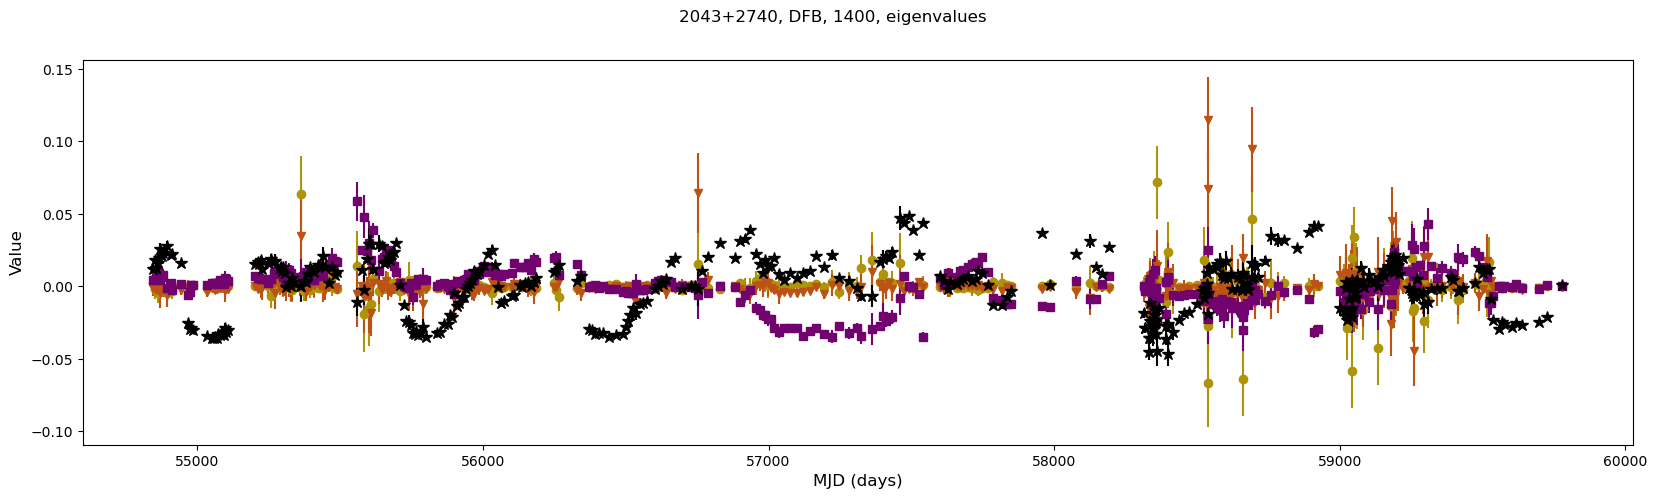

In [8]:
if exist_DFB and True:
    fig = plt.figure(figsize=(20, 5))
    fig.suptitle("{}, DFB, {}, eigenvalues".format(psr, freq))
    ax1 = fig.gca()
    ax1.errorbar(DFB_mjds, DFB_eigval[:,3], yerr=DFB_errs[:,3], fmt='o', ecolor=c4, mec=c4, mfc=c4)
    ax1.errorbar(DFB_mjds, DFB_eigval[:,2], yerr=DFB_errs[:,2], fmt='v', ecolor=c3, mec=c3, mfc=c3)
    ax1.errorbar(DFB_mjds, DFB_eigval[:,1], yerr=DFB_errs[:,1], fmt='s', ecolor=c2, mec=c2, mfc=c2)
    ax1.errorbar(DFB_mjds, DFB_eigval[:,0], yerr=DFB_errs[:,0], fmt='k*', ecolor=c1, ms=9)
    ax1.set_xlabel('MJD (days)', fontsize=12)
    ax1.set_ylabel('Value', fontsize=12)


In [9]:
if exist_DFB:
    print(DFB_mjds[DFB_eigval[:,0] == min(DFB_eigval[:,0])])


[58397.05353]


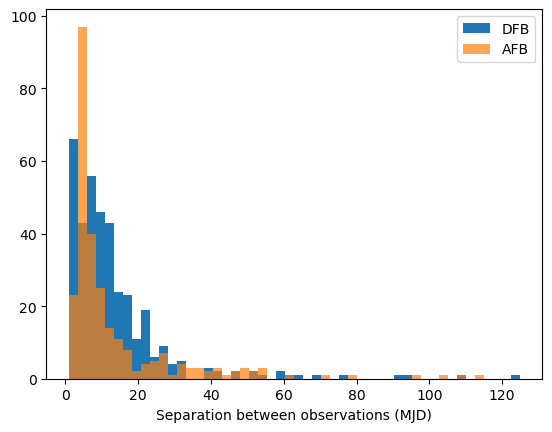

In [10]:
if exist_DFB:
    _, bins, _ = plt.hist(DFB_mjds[1:] - DFB_mjds[:-1], bins=50, label='DFB')
    
if exist_AFB:
    _, _, _ = plt.hist(AFB_mjds[1:] - AFB_mjds[:-1], bins=bins, alpha=0.7, label='AFB')
    
if exist_AFB or exist_DFB:
    plt.xlabel("Separation between observations (MJD)")
    plt.legend()


Running GP for DFB data
Subtracting 54845 from MJDs (will return true MJD values)
Running burn-in
Running production chain


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [10:14<00:00, 32.54it/s]


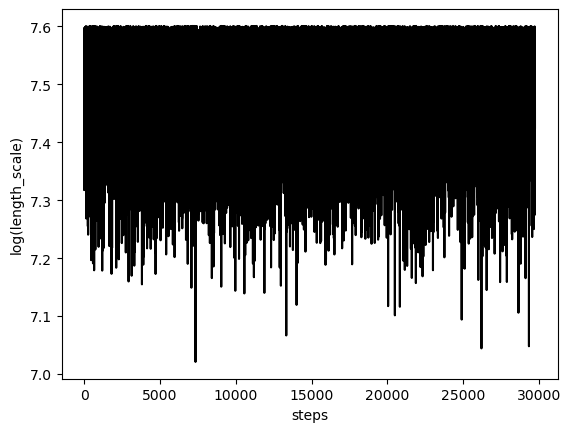

<Figure size 640x480 with 0 Axes>

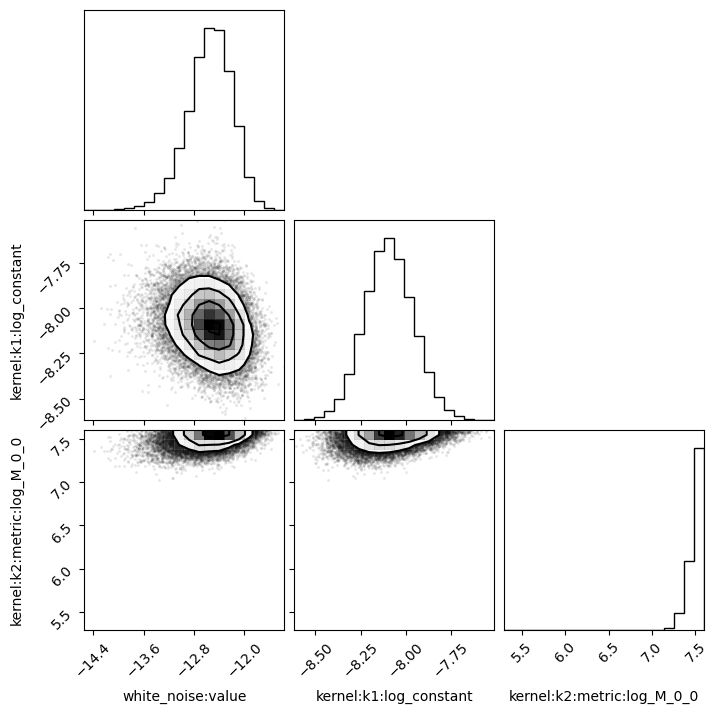

Running burn-in


/home/s86932rs/anaconda3/envs/std/lib/python3.10/site-packages/george/gp.py:330: RuntimeWarning: overflow encountered in exp
  yerr = np.sqrt(self._yerr2 + np.exp(self._call_white_noise(self._x)))
/home/s86932rs/anaconda3/envs/std/lib/python3.10/site-packages/george/gp.py:330: RuntimeWarning: overflow encountered in exp
  yerr = np.sqrt(self._yerr2 + np.exp(self._call_white_noise(self._x)))
/home/s86932rs/anaconda3/envs/std/lib/python3.10/site-packages/george/gp.py:330: RuntimeWarning: overflow encountered in exp
  yerr = np.sqrt(self._yerr2 + np.exp(self._call_white_noise(self._x)))
/home/s86932rs/anaconda3/envs/std/lib/python3.10/site-packages/george/gp.py:330: RuntimeWarning: overflow encountered in exp
  yerr = np.sqrt(self._yerr2 + np.exp(self._call_white_noise(self._x)))
/home/s86932rs/anaconda3/envs/std/lib/python3.10/site-packages/george/gp.py:330: RuntimeWarning: overflow encountered in exp
  yerr = np.sqrt(self._yerr2 + np.exp(self._call_white_noise(self._x)))
/home/s86932rs/

Running production chain


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 17091/20000 [08:36<01:32, 31.33it/s]/home/s86932rs/anaconda3/envs/std/lib/python3.10/site-packages/emcee/moves/stretch.py:33: RuntimeWarning: overflow encountered in subtract
  return c[rint] - (c[rint] - s) * zz[:, None], factors
 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 17094/20000 [08:36<01:27, 33.06it/s]


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/s86932rs/anaconda3/envs/std/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3433, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_11231/211708943.py", line 21, in <module>
    DFB_pred_res, DFB_pred_vars, DFB_mjds_pred = run_each_gp(DFB_eigval, DFB_mjds, DFB_errs, kern_len=1000, max_num=1, prior_min=200, prior_max=2000, long=True, plot_chains=True,
  File "/home/s86932rs/research/nudot_prof_functions.py", line 1887, in run_each_gp
  File "/home/s86932rs/research/nudot_prof_functions.py", line 1825, in get_gp
    sampler, ndim = do_sampling(gp, pool, th_init.lnprob, use_errs, long_chain)
  File "/home/s86932rs/research/nudot_prof_functions.py", line 1788, in do_sampling
    sampler.run_mcmc(samp0, prod_chain, progress=True)
  File "/home/s86932rs/anaconda3/envs/std/lib/python3.10/site-packages/emcee/ensemble.py", line 443, in run_mcmc
    for results in self.sample(initial_stat

In [11]:
read_old = False
gp_file = os.path.join(data_dir, '{}_gps_fin.npz'.format(psr))
if read_old and os.path.exists(gp_file):
    with np.load(gp_file) as d:
        if exist_DFB and 'DFB_mjds_pred' in d.keys():
            DFB_mjds_pred = d['DFB_mjds_pred']
            DFB_pred_vars = d['DFB_vars_pred']
            DFB_pred_res = d['DFB_res_pred']
        else:
            print("No DFB arrays in npz file")
            
        if exist_AFB and 'AFB_mjds_pred' in d.keys():
            AFB_mjds_pred = d['AFB_mjds_pred']
            AFB_pred_vars = d['AFB_vars_pred']
            AFB_pred_res = d['AFB_res_pred']
        else:
            print("No AFB arrays in npz file")
            
if exist_DFB and 'DFB_pred_res' not in locals():
    print("Running GP for DFB data")
    DFB_pred_res, DFB_pred_vars, DFB_mjds_pred = run_each_gp(DFB_eigval, DFB_mjds, DFB_errs, kern_len=1000, max_num=1, prior_min=200, prior_max=2000, long=True, plot_chains=True,
                                                             plot_corner=True, plot=True, mcmc=True, multi=True, gp_plotname=os.path.join(plots_dir, psr+'_dfb_{}_gp_preds.png'.format(freq)))

if exist_AFB and 'AFB_pred_res' not in locals():
    print("Running GP for AFB data")
    AFB_pred_res, AFB_pred_vars, AFB_mjds_pred = run_each_gp(AFB_eigval, AFB_mjds, AFB_errs, kern_len=1000, max_num=3, prior_min=200, prior_max=2000, long=True, plot_chains=True, 
                                                             plot_corner=True, plot=True, mcmc=True, multi=True, gp_plotname=os.path.join(plots_dir, psr+'_afb_{}_gp_preds.png'.format(freq)))
    

In [ ]:
if exist_DFB:
    plot_recon_profs(DFB_mean, DFB_eigvec, DFB_mjds_pred, DFB_pred_res, psr, mjds_real=DFB_mjds,
                     sub_mean=True, savename=os.path.join(plots_dir, psr+'_dfb_recon_wfall.png'))
    

In [ ]:
if exist_AFB:
    plot_recon_profs(AFB_mean, AFB_eigvec, AFB_mjds_pred, AFB_pred_res, psr, mjds_real=AFB_mjds,
                     sub_mean=True, savename=os.path.join(plots_dir, psr+'_afb_recon_wfall.png'))
    

In [ ]:
var_dict = {}
if exist_DFB:
    var_dict['DFB_mjds_pred'] = DFB_mjds_pred
    var_dict['DFB_res_pred'] = DFB_pred_res
    var_dict['DFB_vars_pred'] = DFB_pred_vars
    
if exist_AFB:
    var_dict['AFB_mjds_pred'] = AFB_mjds_pred
    var_dict['AFB_res_pred'] = AFB_pred_res
    var_dict['AFB_vars_pred'] = AFB_pred_vars
    
out_file = os.path.join(data_dir, '{}_gps_fin.npz'.format(psr))
np.savez(out_file, **var_dict)


In [ ]:
if exist_DFB:
    print(len(DFB_errs[np.array([np.isnan(A) for A in DFB_errs[:,0]]),0]), len(AFB_errs[np.array([np.isnan(A) for A in AFB_errs[:,0]]),0]))
    print(DFB_errs.shape, AFB_errs.shape)